In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lusee
import os
import fitsio
import healpy as hp
import scipy.linalg as la
from scipy.ndimage import gaussian_filter

In [3]:
root = os.path.join(os.environ['LUSEE_DRIVE_DIR']+"Simulations/PDR")

def get_fg (l=3, theta=75, R=0):
    fname = f"hfss_lbl_{l}m_{theta}deg_R{R}.fits" if R>0 else f"hfss_lbl_{l}m_{theta}deg.fits"
    return lusee.data.LData(os.path.join(root,fname))
 
def get_CMB (l=3, theta=75):
    fname = f"hfss_lbl_{l}m_{theta}deg_CMB.fits" 
    return lusee.data.LData(os.path.join(root,fname))   

def get_DA (l=3, theta=75,rms=14):
    fname = f"hfss_lbl_{l}m_{theta}deg_{rms}MHz_DA.fits" 
    return lusee.data.LData(os.path.join(root,fname))   

In [4]:
def smooth (v):
    return gaussian_filter(v,(20,3))

def get_data_A(S):
    data=np.vstack(list(map(smooth, [S[:,'00RV',:],S[:,'11RV',:],S[:,'22RV',:],S[:,'33RV',:]])))
    return data

def get_data_X(S):
    data=np.vstack(list(map(smooth,[S[:,'02RV',:],2*S[:,'13RV',:]])))
    return data 

TDA={}
TDA[2] = get_DA(l=2)
TDA[3] = get_DA(l=3)
freq = np.arange(1,51)
def get_sig_A (l,A=0.04,nu_min=16.4, nu_rms=14):
    return TDA[l][0,'00RV',:]*(lusee.monosky.T_DarkAges_Scaled(freq,nu_min=nu_min, nu_rms=nu_rms,A=A)
                           /(1e-100+lusee.monosky.T_DarkAges_Scaled(freq)))
def get_sig_X (l,A=0.04,nu_min=16.4,nu_rms=14):
    return TDA[l][0,'02RV',:]*(lusee.monosky.T_DarkAges_Scaled(freq,nu_min=nu_min, nu_rms=nu_rms,A=A)
                           /(1e-100+lusee.monosky.T_DarkAges_Scaled(freq)))
  
def get_sig_AX(l,A=0.04,nu_min=16.4,nu_rms=14):
    return [get_sig_A(l,A,nu_min,nu_rms), get_sig_X(l,A,nu_min,nu_rms)]

def get_sig_AX_23(A=0.04,nu_min=16.4,nu_rms=14):
    return get_sig_AX(2,A,nu_min,nu_rms)+get_sig_AX(3,A,nu_min,nu_rms)

def get_CMB_AX(l):
    C=get_CMB(l)
    return [C[0,'00RV',:],C[0,'02RV',:]]

In [5]:
SR2 = [get_fg(l=2,R=R) for R in range(10,91,10)]
SR3 = [get_fg(l=3,R=R) for R in range(10,91,10)]


In [6]:
def get_analyzer(SR, errmult=1):
    dA = np.vstack([get_data_A(SX) for SX in SR])
    dX = np.vstack([get_data_X(SX) for SX in SR])
    el = 4e-9
    ncycles=16
    ## cross are two times better, but have two times fewer antennas
    err =(dA.mean(axis=0)+4e-9**2)/np.sqrt(ncycles*14*24*3600*1e6)/np.sqrt(4) # for 4 antennas
    err *=errmult
    wA = 1/dA.mean(axis=0)
    wx = 1/dX.mean(axis=0)
    AA = lusee.PCA_Analyzer(dA,err,wA)
    AX = lusee.PCA_Analyzer(dX,err,wx)
    AC = lusee.Composite_PCA_Analyzer([AA,AX])
    return AC

def get_analyzer23(SR2,SR3):
    A2 = get_analyzer(SR2, errmult=np.sqrt(2))
    A3 = get_analyzer(SR3, errmult=np.sqrt(2))
    return lusee.Composite_PCA_Analyzer(A2.alist+A3.alist)

In [7]:
AC2 = get_analyzer(SR2)
AC3 = get_analyzer(SR3)
AC23 = get_analyzer23(SR2,SR3)

22.93788424796629

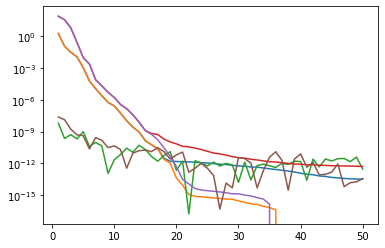

In [8]:
AC2.SNR(get_sig_AX(l=2,A=1),plot=plt)

29.196392760450667

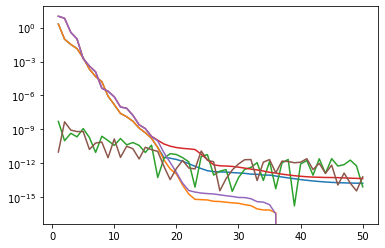

In [9]:
AC3.SNR(get_sig_AX(l=3,A=1),plot=plt)

28.0011902439404

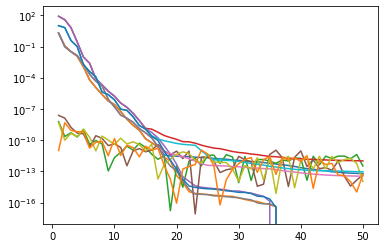

In [10]:
AC23.SNR(get_sig_AX(l=2,A=1)+get_sig_AX(l=3,A=1),plot=plt)

In [11]:
AC=AC3
ell=3

In [12]:
rms_list = np.linspace (3,20,100)
pos_list = np.linspace(10,40,100)
tmin  = [[100/AC.SNR(get_sig_AX(ell,A=1,nu_min=a,nu_rms=b))for a in pos_list]
         for b in rms_list] 
tmin = np.array(tmin)

3.4250806536436125


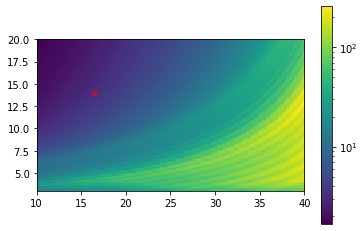

In [13]:
from matplotlib.colors import LogNorm
plt.imshow(tmin,interpolation='nearest', extent=(10,40,3,20), origin='lower',norm=LogNorm())
plt.plot(16.4,14,'rx')
plt.colorbar()
print (100/AC.SNR(get_sig_AX(ell,A=1)))

In [14]:
(AC2.SNR(get_CMB_AX(2)), AC2.SNR(get_sig_AX(2)), 
AC3.SNR(get_CMB_AX(3)), AC3.SNR(get_sig_AX(3)))

(563.3579427305334, 0.9175153699186512, 161.1142643748942, 1.1678557104180263)

563.3579427305334

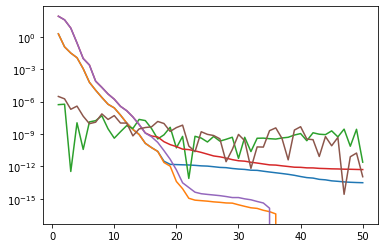

In [15]:
AC2.SNR(get_CMB_AX(l=2),plot=plt)

161.1142643748942

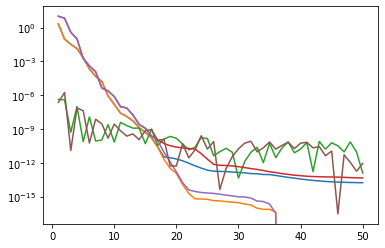

In [16]:
AC3.SNR(get_CMB_AX(l=3),plot=plt)

In [22]:
AC23.SNR(get_CMB_AX(l=2)+get_CMB_AX(l=3))

433.9317086376449

In [17]:
trueA=2
truerms=14
truepos=16.4
A_list = np.linspace(0,4,100)
AC=AC2
ell=2

d = AC.sim_data(get_sig_AX(ell,trueA,nu_min=truepos,nu_rms=truerms))
chi2 = np.array([[AC.get_chi2(get_sig_AX(ell,A,nu_min=pos,nu_rms=truerms),d) 
                  for pos in pos_list]
                  for A in A_list])



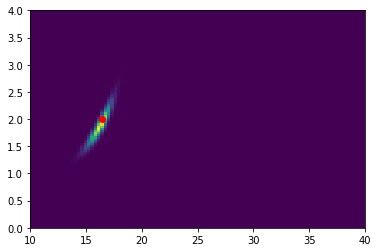

In [18]:
plt.imshow(np.exp(-chi2/10),interpolation='nearest',origin='lower', extent=[10,40,0,4],aspect='auto')
plt.plot(16.4,2,'ro')

In [19]:
chi2.min()

64.67522500920509

In [20]:
trueA=2
truerms=14
truepos=16.4
A_list = np.linspace(0,4,100)

d = AC23.sim_data(get_sig_AX_23(trueA,nu_min=truepos,nu_rms=truerms))
chi2 = np.array([[AC23.get_chi2(get_sig_AX_23(A,nu_min=pos,nu_rms=truerms),d) 
                  for pos in pos_list]
                  for A in A_list])

chi2.min()

151.02906478246314

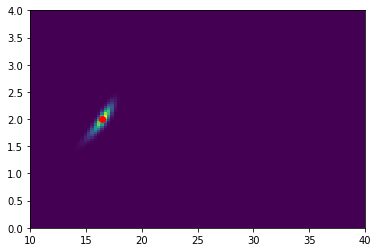

In [21]:
plt.imshow(np.exp(-chi2/10),interpolation='nearest',origin='lower', extent=[10,40,0,4],aspect='auto')
plt.plot(16.4,2,'ro')